# Module import

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
from pathlib import Path
from tqdm.notebook import trange, tqdm

# 再現性のためにrandom seedを設定する
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0


In [2]:
data_dir = "/dataset/dataset/egg_above/"

# Loading dataset

In [3]:
class ImageFolder(Dataset):
    IMG_EXTENSIONS = [".jpg", ".jpeg", ".png", ".bmp", ".JPG"]

    def __init__(self, img_dir, transform=None):
        # 画像ファイルのパス一覧を取得する。
        self.img_paths = self._get_img_paths(img_dir)
        self.transform = transform

    def __getitem__(self, index):
        
        path = self.img_paths[index]

        # 画像を読み込む。
        img = Image.open(path)

        if self.transform is not None:
            # 前処理がある場合は行う。
            img = self.transform(img)

        return img

    def _get_img_paths(self, img_dir):
        """指定したディレクトリ内の画像ファイルのパス一覧を取得する。"""
        img_dir = Path(img_dir)
        img_paths = [
            p for p in img_dir.iterdir() if p.suffix in ImageFolder.IMG_EXTENSIONS
        ]
        img_paths.sort()   

        return img_paths

    def __len__(self):
        """ディレクトリ内の画像ファイルの数を返す。"""
        return len(self.img_paths)

In [4]:
# Transform を作成する
transform = torchvision.transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Dataset を作成する。
dataset = ImageFolder(img_dir= data_dir, transform=transform)
train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
test_dataset = ImageFolder(data_dir, transform=transform)

In [5]:
len(dataset)

340

In [6]:
print(dataset)
print(train_dataset, train_size)
print(val_dataset,validation_size)
print(test_dataset[0].size())

<torch.utils.data.dataset.Subset object at 0x7f730e95afd0> 272
<torch.utils.data.dataset.Subset object at 0x7f730ebd2908> 68
torch.Size([3, 4000, 6000])


In [9]:
loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, drop_last=False)
sample = next(iter(loader))
grid = torchvision.utils.make_grid(sample, nrow=8, padding=1, normalize=True)
plt.rcParams["figure.figsize"] = (64, 48) 
plt.imshow(grid.numpy().transpose(1,2,0))

RuntimeError: DataLoader worker (pid(s) 32178) exited unexpectedly

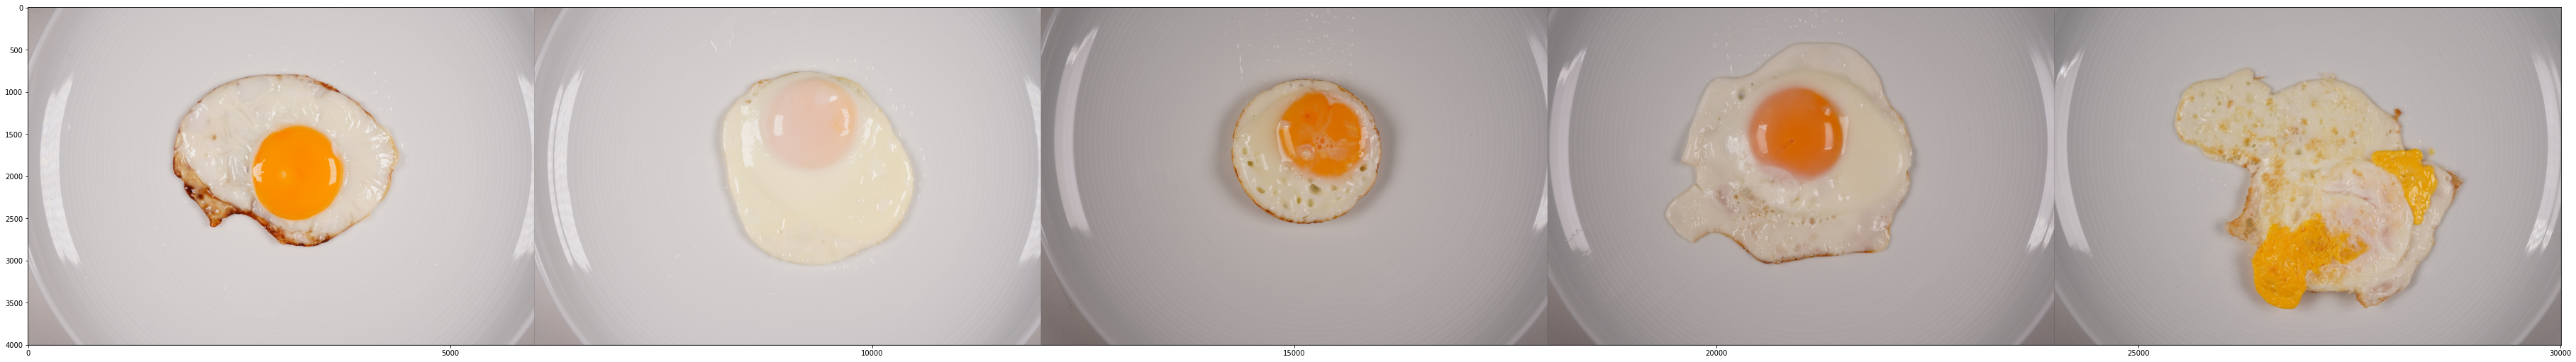

In [8]:
loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, drop_last=False)
sample = next(iter(loader))
grid = torchvision.utils.make_grid(sample, nrow=8, padding=1, normalize=True)
plt.rcParams["figure.figsize"] = (64, 48)
plt.imshow(grid.numpy().transpose(1,2,0))

# Model building

In [5]:
# 訓練中のバッチサイズ
batch_size = 32

# 訓練画像の高さと幅のサイズ
image_size = 256

# 訓練画像のチャンネル数。カラー画像の場合は3。
nc = 3

# 特徴マップのサイズ
nf = 8

In [6]:
class EncodeBlock(nn.Module):
    def __init__(self, in_feature, out_feature, use_bn, act_type, use_pool):
        super(EncodeBlock, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature

        layers = []
        layers.append(nn.Conv2d(in_feature, out_feature, kernel_size=3, stride=1, padding=1))
        if use_bn: layers.append(nn.BatchNorm2d(out_feature))
        if (act_type=='LReLU'): layers.append(nn.LeakyReLU(0.2, inplace=True))
        if (act_type=='Tanh'): layers.append(nn.Tanh())
        if use_pool: layers.append(nn.AvgPool2d(kernel_size=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)      

class DecodeBlock(nn.Module):
    def __init__(self, in_feature, out_feature, use_bn, act_type, use_upsamp):
        super(DecodeBlock, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature

        layers = []
        if use_upsamp: layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
        layers.append(nn.Conv2d(in_feature, out_feature, kernel_size=3, stride=1, padding=1))
        if use_bn: layers.append(nn.BatchNorm2d(out_feature))
        if (act_type=='LReLU'):layers.append(nn.LeakyReLU(0.2, inplace=True))
        if (act_type=='Tanh'):layers.append(nn.Tanh())
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
          
        # 入力： (nc) x 256 x 256
        self.enc1 = EncodeBlock(nc, nf, use_bn=False, act_type='LReLU', use_pool=True)
        # サイズ： (nf) x 128 x 128        
        self.enc2 = EncodeBlock(nf, nf * 2, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*2) x 64 x 64
        self.enc3 = EncodeBlock(nf * 2, nf * 4, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*4) x 32 x 32
        self.enc4 = EncodeBlock(nf * 4, nf * 8, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*8) x 16 x 16
        self.enc5 = EncodeBlock(nf * 8, nf * 16, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*16) x 8 x 8
        self.enc6 = EncodeBlock(nf * 16, nf * 32, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*32) x 4 x 4
        
        self.dec6 = DecodeBlock(nf * 32, nf * 16, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*16) x 8 x 8
        self.dec5 = DecodeBlock(nf * 16, nf * 8, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*8) x 16 x 16
        self.dec4 = DecodeBlock(nf * 8, nf * 4, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*4) x 32 x 32
        self.dec3 = DecodeBlock(nf * 4, nf * 2, use_bn=True, act_type='LReLU', use_upsamp=True)      
        # サイズ： (nf*2) x 64 x 64        
        self.dec2 = DecodeBlock(nf * 2, nf, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf) x 128 x 128        
        self.dec1 = DecodeBlock(nf, nc, use_bn=False, act_type='Tanh', use_upsamp=True)
        # サイズ： (nc) x 256 x 256
        

        
    def forward(self, input):
        #Encode       
        enc1 = self.enc1(input)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        
        #Decode
        dec6 = self.dec6(enc6)
        dec5 = self.dec5(dec6)
        dec4 = self.dec4(dec5)
        dec3 = self.dec3(dec4)
        dec2 = self.dec2(dec3)
        dec1 = self.dec1(dec2)
        
        x = dec1
        
        return x

In [8]:
# カスタムの重み初期化用関数。
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0.2, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0) 

# Setting

In [9]:
# 再現性のためにrandom seedを設定する
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

output_dir = 'results/dim_reduction/256,4,4_all'
os.makedirs(output_dir, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = AutoEncoder()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)
model.apply(weights_init)

num_epochs = 100
lr = 0.001

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model, input_size=(batch_size, nc, image_size, image_size))

Random Seed:  0
cuda


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              --                        --
├─EncodeBlock: 1-1                       [32, 8, 128, 128]         --
│    └─Sequential: 2-1                   [32, 8, 128, 128]         --
│    │    └─Conv2d: 3-1                  [32, 8, 256, 256]         224
│    │    └─LeakyReLU: 3-2               [32, 8, 256, 256]         --
│    │    └─AvgPool2d: 3-3               [32, 8, 128, 128]         --
├─EncodeBlock: 1-2                       [32, 16, 64, 64]          --
│    └─Sequential: 2-2                   [32, 16, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 16, 128, 128]        1,168
│    │    └─BatchNorm2d: 3-5             [32, 16, 128, 128]        32
│    │    └─LeakyReLU: 3-6               [32, 16, 128, 128]        --
│    │    └─AvgPool2d: 3-7               [32, 16, 64, 64]          --
├─EncodeBlock: 1-3                       [32, 32, 32, 32]          --
│    └─Sequ

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False)

# Train

In [11]:
history = {
    'train_loss': [],
    'valid_loss': [],
}

# Train Step
for epoch in range(num_epochs):
    loop = tqdm(train_loader, unit='batch', desc='| Train | Epoch {:>3} |'.format(epoch+1))

    model.train()

    batch_loss = []

    for batch in loop:
        inputs = batch
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
       
        batch_loss.append(loss)

    train_avg_loss = torch.tensor(batch_loss).mean()

    batch_loss = []

    model.eval()

    # Validation Step
    with torch.no_grad():
        model.eval()
        loop_val = tqdm(val_loader, unit='batch', desc='| Test  | Epoch {:>3} |'.format(epoch + 1))

        for i, batch in enumerate(loop_val):
            inputs = batch
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            batch_loss.append(loss)

        valid_avg_loss = torch.tensor(batch_loss).mean()

    history['train_loss'].append(train_avg_loss)
    history['valid_loss'].append(valid_avg_loss)
    
    print(f"epoch: {epoch+1}, train_loss: {train_avg_loss:.3f}, valid_loss: {valid_avg_loss:.3f}")

print('Finished Training')

| Train | Epoch   1 |:   0%|          | 0/8 [00:00<?, ?batch/s]

RuntimeError: DataLoader worker (pid(s) 31822) exited unexpectedly

# Plot

In [ ]:
plt.figure(figsize=(8, 4.5))
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend(['Train', 'Valid'], loc='upper right')
plt.grid(True)
loss_name = 'loss.png'
loss_path = os.path.join(output_dir, loss_name)
plt.savefig(loss_path)
plt.show()

model_name = 'autoencoder.pth'
model_path = os.path.join(output_dir, model_name)
torch.save(model.state_dict(), model_path)

In [ ]:
original_imgs = []
decoded_imgs = []
diff_imgs = []

scores = []

model = AutoEncoder()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.load_state_dict(torch.load('./results/dim_reduction/256,4,4_all/autoencoder.pth'))
model.to(device)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        original = batch
        original = original.to(device, non_blocking=True)
        decoded = model(original)
        diff = torch.abs(original - decoded)
        score = torch.mean(diff.view(diff.shape[0], -1), dim=1)
        
        original_imgs.extend(original.detach().cpu().numpy())
        decoded_imgs.extend(decoded.detach().cpu().numpy())
        diff_imgs.extend(diff.detach().cpu().numpy())
        scores.extend(score.detach().cpu().numpy())

original_imgs = np.array(original_imgs).transpose(0, 2, 3, 1)
decoded_imgs = np.array(decoded_imgs).transpose(0, 2, 3, 1)
diff_imgs = np.array(diff_imgs).transpose(0, 2, 3, 1)
scores = np.array(scores)

In [ ]:
# 入力画像(左)、出力画像(中)、差分画像(右)の順に表示
plt.figure(figsize=(20, 20))
for i in range(24):
    img = np.hstack((original_imgs[i], decoded_imgs[i], diff_imgs[i]))
    ax = plt.subplot(8, 3, i+1)
    img = np.clip((img+1)/2, 0., 1.)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#     if scores[i] > th[6]:
#         plt.title(str(scores[i]), color='r')
#     else:
#         plt.title(str(scores[i]))

diff_name = 'diff.png'
diff_path = os.path.join(output_dir, diff_name)
plt.savefig(diff_path)
plt.show()

# Extract

In [ ]:
def extract(target, inputs):
    feature = None

    def forward_hook(module, inputs, outputs):
        global features
        features = outputs.detach().clone()      

    handle = target.register_forward_hook(forward_hook)
    model.eval()
    model(inputs)
    handle.remove()

    return features


model = AutoEncoder()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.load_state_dict(torch.load('./results/dim_reduction/256,4,4_all/autoencoder.pth'))
model.to(device)

flatten = nn.Flatten()
features_list = []

# 抽出対象の層
target_module = model.module.enc6.block[3]

with torch.no_grad():
    for batch in test_loader:
        inputs = batch
        inputs = inputs.to(device, non_blocking=True)
        features = extract(target_module, inputs)
        flatten_features = flatten(features)
        features_list.extend(flatten_features.detach().cpu().numpy())
        
features_list = np.array(features_list)
print(features.shape)
print(flatten_features.shape)
print(features_list.shape)

np_name = 'feature'
np_path = os.path.join(output_dir, np_name)
np.save(np_path, features_list)

Let's use 2 GPUs!
torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])
(1980, 4096)


# Upsamp

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
          
        # 入力： (NC) x 256 x 256
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=3, stride=1, padding=1, bias=False)
        self.act1 = nn.LeakyReLU(0.2, inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf) x 128 x 128

        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.act2 = nn.LeakyReLU(0.2, inplace=True)            
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*2) x 64 x 64

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.act3 = nn.LeakyReLU(0.2, inplace=True)
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        # サイズ：(ndf*4) x 32 x 32

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.act4 = nn.LeakyReLU(0.2, inplace=True)
        self.pool4 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*8) x 16 x 16

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        self.act5 = nn.LeakyReLU(0.2, inplace=True)
        self.pool5 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*16) x 8 x 8

        self.conv6 = nn.Conv2d(ndf * 16, ndf * 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 32)
        self.act6 = nn.LeakyReLU(0.2, inplace=True)
        self.pool6 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*32) x 4 x 4
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(ndf*32*4*4, z)
        self.fcact1 = nn.Tanh()
        self.fc2 = nn.Linear(z, ndf*32*4*4)
        self.fcact2 = nn.LeakyReLU(0.2, inplace=True)
        self.fcupsamp = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ： (ndf*32) x 8 x 8

        self.convt7 = nn.ConvTranspose2d( ngf * 32, ngf * 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf * 16)
        self.act7 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp7 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ： (ndf*16) x 16 x 16

        self.convt8 = nn.ConvTranspose2d( ngf * 16, ngf * 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(ngf * 8)
        self.act8 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp8 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*8) x 32 x 32

        self.convt9 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf * 4)
        self.act9 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp9 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*4) x 64 x 64

        self.convt10 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf * 2)
        self.act10 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp10 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*2) x 128 x 128

        self.convt11 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf)
        self.act11 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp11 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf) x 256 x 256

        self.convt12 = nn.ConvTranspose2d( ngf, nc, kernel_size=3, stride=1, padding=1, bias=False)
        self.act12 = nn.Tanh()
        # サイズ： (nc) x 256 x 256

    def forward(self, input):
        conv1 = self.conv1(input)
        act1 = self.act1(conv1)
        pool1 = self.pool1(act1)
        
        conv2 = self.conv2(pool1)
        bn2 = self.bn2(conv2)
        act2 = self.act2(bn2)
        pool2 = self.pool2(act2)
        
        conv3 = self.conv3(pool2)
        bn3 = self.bn3(conv3)
        act3 = self.act3(bn3)
        pool3 = self.pool3(act3)
        
        conv4 = self.conv4(pool3)
        bn4 = self.bn4(conv4)
        act4 = self.act4(bn4)
        pool4 = self.pool4(act4)
        
        conv5 = self.conv5(pool4)
        bn5 = self.bn5(conv5)
        act5 = self.act5(bn5)
        pool5 = self.pool5(act5)
        
        conv6 = self.conv6(pool5)
        bn6 = self.bn6(conv6)
        act6 = self.act6(bn6)
        pool6 = self.pool6(act6)
        
        flatten = self.flatten(pool6)
        fc1 = self.fc1(flatten)
        fcact1 = self.fcact1(fc1)
        fc2 = self.fc2(fcact1)
        fcact2 = self.fcact2(fc2)
        reshape = fcact2.view((-1, 256, 4, 4))
        fcupsamp = self.fcupsamp(reshape)
        
        convt7 = self.convt7(fcupsamp)
        bn7 = self.bn7(convt7)
        act7 = self.act7(bn7)
        upsamp7 = self.upsamp7(act7)
        
        convt8 = self.convt8(upsamp7)
        bn8 = self.bn8(convt8)
        act8 = self.act8(bn8)
        upsamp8 = self.upsamp8(act8)
        
        convt9 = self.convt9(upsamp8)
        bn9 = self.bn9(convt9)
        act9 = self.act9(bn9)
        upsamp9 = self.upsamp9(act9)
        
        convt10 = self.convt10(upsamp9)
        bn10 = self.bn10(convt10)
        act10 = self.act10(bn10)
        upsamp10 = self.upsamp10(act10)
        
        convt11 = self.convt11(upsamp10)
        bn11 = self.bn11(convt11)
        act11 = self.act11(bn11)
        upsamp11 = self.upsamp11(act11)
        
        convt12 = self.convt12(upsamp11)
        act12 = self.act12(convt12)        
        
        x = act12
        
        return x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
          
        # 入力： (nc) x 256 x 256
        self.enc1 = EncodeBlock(nc, nf, use_bn=False, act_type='LReLU', use_pool=True)
        # サイズ： (nf) x 128 x 128        
        self.enc2 = EncodeBlock(nf, nf * 2, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*2) x 64 x 64
        self.enc3 = EncodeBlock(nf * 2, nf * 4, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*4) x 32 x 32
        self.enc4 = EncodeBlock(nf * 4, nf * 8, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*8) x 16 x 16
        self.enc5 = EncodeBlock(nf * 8, nf * 16, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*16) x 8 x 8
        # self.enc6 = EncodeBlock(nf * 16, nf * 32, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*32) x 4 x 4
        # self.enc7 = EncodeBlock(nf * 32, nf * 64, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*64) x 2 x 2
        # self.enc8 = EncodeBlock(nf * 64, nf * 128, use_bn=True, act_type='LReLU', use_pool=True)
        # サイズ： (nf*128) x 1 x 1
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nf*16*8*8, z)
        self.fcact1 = nn.LeakyReLU(0.2, inplace=True)
        self.fc2 = nn.Linear(z, nf*16*8*8)
        self.fcact2 = nn.LeakyReLU(0.2, inplace=True)
                
        # self.dec8 = DecodeBlock(nf * 128, nf * 64, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*64) x 2 x 2
        # self.dec7 = DecodeBlock(nf * 64, nf * 32, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*32) x 4 x 4
        # self.dec6 = DecodeBlock(nf * 32, nf * 16, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*16) x 8 x 8
        self.dec5 = DecodeBlock(nf * 16, nf * 8, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*8) x 16 x 16
        self.dec4 = DecodeBlock(nf * 8, nf * 4, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf*4) x 32 x 32
        self.dec3 = DecodeBlock(nf * 4, nf * 2, use_bn=True, act_type='LReLU', use_upsamp=True)      
        # サイズ： (nf*2) x 64 x 64        
        self.dec2 = DecodeBlock(nf * 2, nf, use_bn=True, act_type='LReLU', use_upsamp=True)
        # サイズ： (nf) x 128 x 128        
        self.dec1 = DecodeBlock(nf, nc, use_bn=False, act_type='Tanh', use_upsamp=True)
        # サイズ： (nc) x 256 x 256
        

        
    def forward(self, input):
        #Encode       
        enc1 = self.enc1(input)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        # enc6 = self.enc6(enc5)
        # enc7 = self.enc7(enc6)
        # enc8 = self.enc8(enc7)
        
        flatten = self.flatten(enc5)
        fc1 = self.fc1(flatten)
        fcact1 = self.fcact1(fc1)
        fc2 = self.fc2(fcact1)
        fcact2 = self.fcact2(fc2)
        reshape = fcact2.view((-1, 128, 8, 8))
        
        # dec8 = self.dec8(reshape)
        # dec7 = self.dec7(reshape)
        # dec6 = self.dec6(reshape)
        dec5 = self.dec5(reshape)
        dec4 = self.dec4(dec5)
        dec3 = self.dec3(dec4)
        dec2 = self.dec2(dec3)
        dec1 = self.dec1(dec2)
        
        x = dec1
        
        return x

# ConvT

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
          
        # 入力： (NC) x 256 x 256
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=3, stride=1, padding=1, bias=False)
        self.act1 = nn.LeakyReLU(0.2, inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf) x 128 x 128

        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.act2 = nn.LeakyReLU(0.2, inplace=True)            
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*2) x 64 x 64

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.act3 = nn.LeakyReLU(0.2, inplace=True)
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        # サイズ：(ndf*4) x 32 x 32

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.act4 = nn.LeakyReLU(0.2, inplace=True)
        self.pool4 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*8) x 16 x 16

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        self.act5 = nn.LeakyReLU(0.2, inplace=True)
        self.pool5 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*16) x 8 x 8

        self.conv6 = nn.Conv2d(ndf * 16, ndf * 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 32)
        self.act6 = nn.LeakyReLU(0.2, inplace=True)
        self.pool6 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*32) x 4 x 4
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(ndf*32*4*4, z)
        self.fcact1 = nn.Tanh()
        self.fc2 = nn.Linear(z, ndf*32*4*4)
        self.fcact2 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ： (ndf*32) x 4 x 4

        self.convt7 = nn.ConvTranspose2d( ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf * 16)
        self.act7 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ： (ndf*16) x 8 x 8

        self.convt8 = nn.ConvTranspose2d( ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(ngf * 8)
        self.act8 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ：(ngf*8) x 16 x 16

        self.convt9 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf * 4)
        self.act9 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ：(ngf*4) x 32 x 32

        self.convt10 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf * 2)
        self.act10 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ：(ngf*2) x 64 x 64

        self.convt11 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf)
        self.act11 = nn.LeakyReLU(0.2, inplace=True)
        # サイズ：(ngf) x 128 x 128

        self.convt12 = nn.ConvTranspose2d( ngf, nc, kernel_size=4, stride=2, padding=1, bias=False)
        self.act12 = nn.Tanh()
        # サイズ： (nc) x 256 x 256

    def forward(self, input):
        conv1 = self.conv1(input)
        act1 = self.act1(conv1)
        pool1 = self.pool1(act1)
        
        conv2 = self.conv2(pool1)
        bn2 = self.bn2(conv2)
        act2 = self.act2(bn2)
        pool2 = self.pool2(act2)
        
        conv3 = self.conv3(pool2)
        bn3 = self.bn3(conv3)
        act3 = self.act3(bn3)
        pool3 = self.pool3(act3)
        
        conv4 = self.conv4(pool3)
        bn4 = self.bn4(conv4)
        act4 = self.act4(bn4)
        pool4 = self.pool4(act4)
        
        conv5 = self.conv5(pool4)
        bn5 = self.bn5(conv5)
        act5 = self.act5(bn5)
        pool5 = self.pool5(act5)
        
        conv6 = self.conv6(pool5)
        bn6 = self.bn6(conv6)
        act6 = self.act6(bn6)
        pool6 = self.pool6(act6)
        
        flatten = self.flatten(pool6)
        fc1 = self.fc1(flatten)
        fcact1 = self.fcact1(fc1)
        fc2 = self.fc2(fcact1)
        fcact2 = self.fcact2(fc2)
        reshape = fcact2.view((-1, 256, 4, 4))
        
        convt7 = self.convt7(reshape)
        bn7 = self.bn7(convt7)
        act7 = self.act7(bn7)
        
        convt8 = self.convt8(act7)
        bn8 = self.bn8(convt8)
        act8 = self.act8(bn8)
        
        convt9 = self.convt9(act8)
        bn9 = self.bn9(convt9)
        act9 = self.act9(bn9)
        
        convt10 = self.convt10(act9)
        bn10 = self.bn10(convt10)
        act10 = self.act10(bn10)
        
        convt11 = self.convt11(act10)
        bn11 = self.bn11(convt11)
        act11 = self.act11(bn11)
        
        convt12 = self.convt12(act11)
        act12 = self.act12(convt12)        
        
        x = act12
        
        return x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
          
        # 入力： (NC) x 256 x 256
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=3, stride=1, padding=1, bias=False)
        self.act1 = nn.LeakyReLU(0.2, inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf) x 128 x 128

        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.act2 = nn.LeakyReLU(0.2, inplace=True)            
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*2) x 64 x 64

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.act3 = nn.LeakyReLU(0.2, inplace=True)
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        # サイズ：(ndf*4) x 32 x 32

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.act4 = nn.LeakyReLU(0.2, inplace=True)
        self.pool4 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*8) x 16 x 16

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        self.act5 = nn.LeakyReLU(0.2, inplace=True)
        self.pool5 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*16) x 8 x 8

        self.conv6 = nn.Conv2d(ndf * 16, ndf * 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 32)
        self.act6 = nn.LeakyReLU(0.2, inplace=True)
        self.pool6 = nn.AvgPool2d(kernel_size=2)
        # サイズ： (ndf*32) x 4 x 4
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(ndf*32*4*4, z)
        self.fcact1 = nn.Tanh()
        self.fc2 = nn.Linear(z, ndf*32*4*4)
        self.fcact2 = nn.LeakyReLU(0.2, inplace=True)
        self.fcupsamp = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ： (ndf*32) x 8 x 8

        self.convt7 = nn.ConvTranspose2d( ngf * 32, ngf * 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf * 16)
        self.act7 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp7 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ： (ndf*16) x 16 x 16

        self.convt8 = nn.ConvTranspose2d( ngf * 16, ngf * 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(ngf * 8)
        self.act8 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp8 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*8) x 32 x 32

        self.convt9 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf * 4)
        self.act9 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp9 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*4) x 64 x 64

        self.convt10 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf * 2)
        self.act10 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp10 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf*2) x 128 x 128

        self.convt11 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf)
        self.act11 = nn.LeakyReLU(0.2, inplace=True)
        self.upsamp11 = nn.Upsample(scale_factor=2, mode='nearest')
        # サイズ：(ngf) x 256 x 256

        self.convt12 = nn.ConvTranspose2d( ngf, nc, kernel_size=3, stride=1, padding=1, bias=False)
        self.act12 = nn.Tanh()
        # サイズ： (nc) x 256 x 256

    def forward(self, input):
        conv1 = self.conv1(input)
        act1 = self.act1(conv1)
        pool1 = self.pool1(act1)
        
        conv2 = self.conv2(pool1)
        bn2 = self.bn2(conv2)
        act2 = self.act2(bn2)
        pool2 = self.pool2(act2)
        
        conv3 = self.conv3(pool2)
        bn3 = self.bn3(conv3)
        act3 = self.act3(bn3)
        pool3 = self.pool3(act3)
        
        conv4 = self.conv4(pool3)
        bn4 = self.bn4(conv4)
        act4 = self.act4(bn4)
        pool4 = self.pool4(act4)
        
        conv5 = self.conv5(pool4)
        bn5 = self.bn5(conv5)
        act5 = self.act5(bn5)
        pool5 = self.pool5(act5)
        
        conv6 = self.conv6(pool5)
        bn6 = self.bn6(conv6)
        act6 = self.act6(bn6)
        pool6 = self.pool6(act6)
        
        flatten = self.flatten(pool6)
        fc1 = self.fc1(flatten)
        fcact1 = self.fcact1(fc1)
        fc2 = self.fc2(fcact1)
        fcact2 = self.fcact2(fc2)
        reshape = fcact2.view((-1, 256, 4, 4))
        fcupsamp = self.fcupsamp(reshape)
        
        convt7 = self.convt7(fcupsamp)
        bn7 = self.bn7(convt7)
        act7 = self.act7(bn7)
        upsamp7 = self.upsamp7(act7)
        
        convt8 = self.convt8(upsamp7)
        bn8 = self.bn8(convt8)
        act8 = self.act8(bn8)
        upsamp8 = self.upsamp8(act8)
        
        convt9 = self.convt9(upsamp8)
        bn9 = self.bn9(convt9)
        act9 = self.act9(bn9)
        upsamp9 = self.upsamp9(act9)
        
        convt10 = self.convt10(upsamp9)
        bn10 = self.bn10(convt10)
        act10 = self.act10(bn10)
        upsamp10 = self.upsamp10(act10)
        
        convt11 = self.convt11(upsamp10)
        bn11 = self.bn11(convt11)
        act11 = self.act11(bn11)
        upsamp11 = self.upsamp11(act11)
        
        convt12 = self.convt12(upsamp11)
        act12 = self.act12(convt12)        
        
        x = act12
        
        return x